<a href="https://colab.research.google.com/github/valanm22/Miscellaneous/blob/main/VOCSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import math
from PIL import Image

In [ ]:
NUM_EPOCHS = 10
LEANRING_RATE = 0.001
BATCH_SIZE = 64

In [ ]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),
                                                     (0.229, 0.224, 0.225))])

target_transform = transforms.Compose([transforms.Resize((256, 256)),
                                transforms.PILToTensor()])

# Creating the dataset
train = datasets.VOCSegmentation('./datasets/', year='2007', download=True,
                                 image_set='train', transform=transform,
                                 target_transform=target_transform)

test = datasets.VOCSegmentation('./data/VOC/', year='2007', download=True,
                                image_set='test', transform=transform, 
                                target_transform=target_transform)

Using downloaded and verified file: ./datasets/VOCtrainval_06-Nov-2007.tar
Extracting ./datasets/VOCtrainval_06-Nov-2007.tar to ./datasets/
Using downloaded and verified file: ./data/VOC/VOCtest_06-Nov-2007.tar
Extracting ./data/VOC/VOCtest_06-Nov-2007.tar to ./data/VOC/


In [ ]:
#Creating dataloaders
train_loader = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=2)

In [ ]:
train[0][0].size()

torch.Size([3, 256, 256])

In [ ]:
train[0][1].size()

torch.Size([1, 256, 256])

In [ ]:
viz = datasets.VOCSegmentation('./datasets/', year='2007', download=True,
                               image_set='train',
                               transform=transforms.Resize((256, 256)),
                               target_transform=transforms.Resize((256, 256)))


Using downloaded and verified file: ./datasets/VOCtrainval_06-Nov-2007.tar
Extracting ./datasets/VOCtrainval_06-Nov-2007.tar to ./datasets/


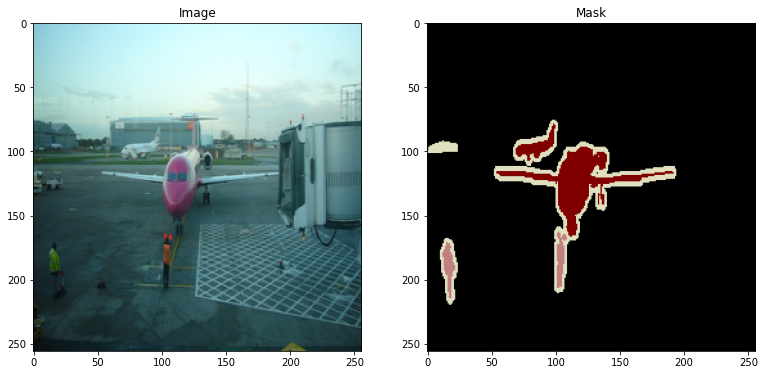

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
plt.imshow(viz[0][0])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(viz[0][1])
plt.title('Mask')

plt.show()

In [ ]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = torch.sigmoid(self.t_conv2(x))
                
        return x


In [ ]:
model = ConvAutoencoder()
model

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
cost_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr= LEANRING_RATE)

In [ ]:
for data in train_loader:
      images, labels = data
      
      output = model(images)
      print(images.size())
      print(labels.size())
      print(output.size())
      break

torch.Size([64, 3, 256, 256])
torch.Size([64, 1, 256, 256])
torch.Size([64, 1, 256, 256])


In [ ]:
for epoch in range(NUM_EPOCHS):

  train_loss = 0.0

  for data in train_loader:
      images, labels = data
      
      output = model(images)
      labels = labels.to(torch.float32) 
      cost = cost_function(output, labels)

      optimizer.zero_grad()
      cost.backward()
      optimizer.step()

      train_loss += cost.item()*images.size(0)
          
  train_loss = train_loss/len(train_loader)
  print('Epoch[{}/{}], loss: {:.6f}'
        .format(epoch + 1, NUM_EPOCHS, train_loss))

Epoch[1/10], loss: 237.446819
Epoch[2/10], loss: 226.545195
Epoch[3/10], loss: 213.098794
Epoch[4/10], loss: 193.285358
Epoch[5/10], loss: 163.175197
Epoch[6/10], loss: 120.282821
Epoch[7/10], loss: 57.264699
Epoch[8/10], loss: -26.888339
Epoch[9/10], loss: -147.286520
Epoch[10/10], loss: -315.368662


In [ ]:
dataiter = next(iter(test_loader))
print(dataiter[0][0].size())
print(dataiter[1][0].size())
output = model(dataiter[0][0])
print(output.size())

torch.Size([3, 256, 256])
torch.Size([1, 256, 256])
torch.Size([1, 256, 256])


In [ ]:
test_viz = datasets.VOCSegmentation('./datasets/', year='2007', download=True,
                               image_set='test',
                               transform=transforms.Resize((256, 256)),
                               target_transform=transforms.Resize((256, 256)))


  0%|          | 0/451020800 [00:00<?, ?it/s]

Extracting ./datasets/VOCtest_06-Nov-2007.tar to ./datasets/


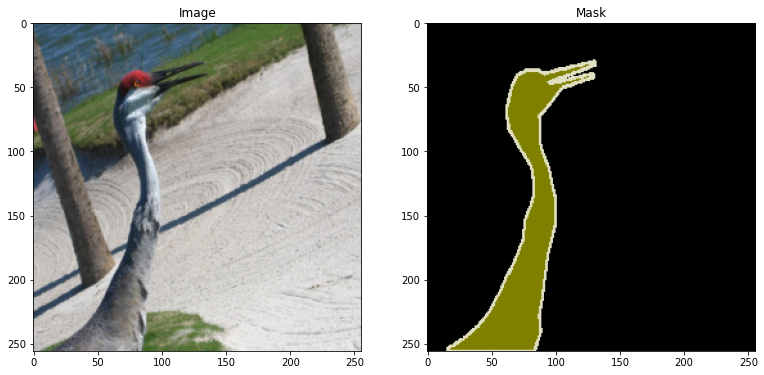

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
plt.imshow(test_viz[0][0])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(test_viz[0][1])
plt.title('Mask')

plt.show()

torch.Size([256, 256, 3])


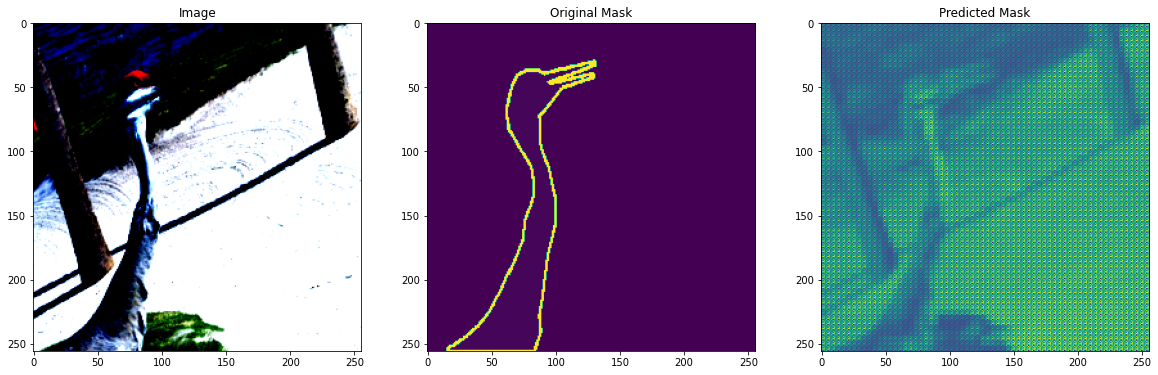

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1,3,1)
img = dataiter[0][0]
img = img.permute(1, 2, 0)
plt.imshow(img)
print(img.size())
plt.title('Image')

plt.subplot(1,3,2)
mask = dataiter[1][0].numpy()
mask = mask.squeeze()
plt.imshow(mask)
plt.title('Original Mask')

plt.subplot(1,3,3)
prediction = output.detach().numpy()
prediction = prediction.squeeze()
plt.imshow(prediction)
plt.title('Predicted Mask')

plt.show()